In [5]:
%matplotlib inline

from dicom_utils import *
import numpy as np 
import pandas as pd 
import os
import pydicom
import matplotlib.pyplot as plt
#import assd_func as af
from skimage import morphology
import matplotlib.patches as mpatches
import assd_func_Sobel_2 as af_Sobel

In [6]:
dicom_dir = "C:\\Users\\lykha\\OneDrive\\Documents\\1_PhD_Fall_2020\\Research_MDA\\Prostate Cases\\1"
output_dir = "Output"
images, slices, contours, labels, dummy_mask = main(dicom_dir, output_dir)

In [7]:
contour_table = pd.DataFrame()
number = []
name = []
for i in range(24):
    number.append(contours[i]["number"])
    name.append(contours[i]["name"])
#contour_table["number"] = number
contour_table["name"] = name

In [8]:
contour_table

,name
0,marked iso
1,a prostate
2,b SV
3,PTV
4,d rectum
5,e bladder
6,f Femural Heads
7,g nt avoid
8,fiducials
9,p ring


# Prostate

In [9]:
#Find location of the contour where labels == 1 (prostate)
a = np.argwhere(labels==True)
a[a[..., 3] == 1][0]

array([ 63, 246, 245,   1], dtype=int64)

(-0.5, 511.5, 511.5, -0.5)

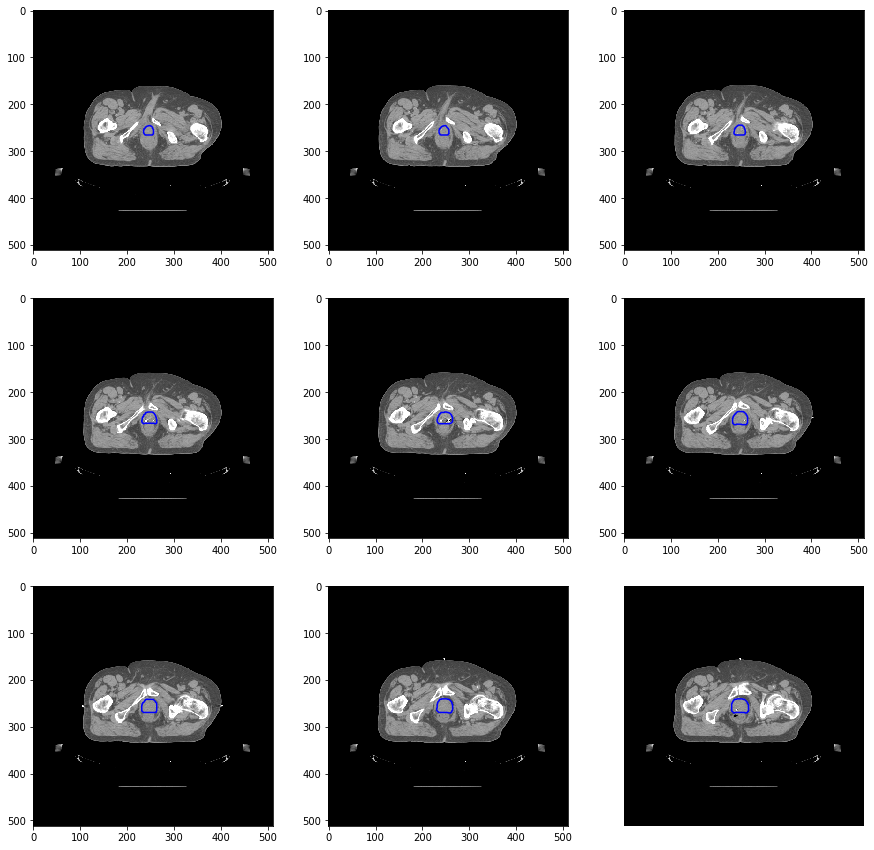

In [10]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i + 63, ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(labels[..., 1][i + 63, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.axis('off')

# rectum

In [11]:
#Find location of the contour where labels == 4 (rectum)
a = np.argwhere(labels==True)
a[a[..., 3] == 4][0]

array([ 55, 280, 246,   4], dtype=int64)

(-0.5, 511.5, 511.5, -0.5)

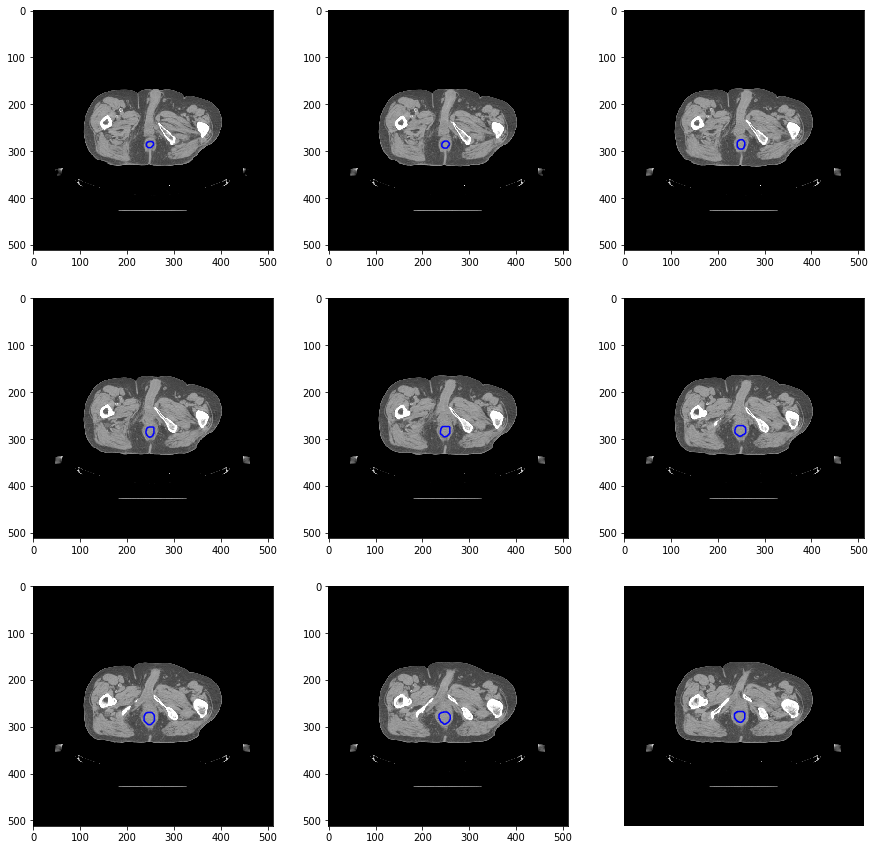

In [12]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i + 55, ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(labels[..., 4][i + 55, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.axis('off')

# Sobel and 3D Permutation

In [13]:
import random
from scipy.stats import uniform,norm

random.seed(1)
random.random()

0.13436424411240122

In [14]:
random.seed(123)
random.random()

0.052363598850944326

In [15]:
target_img1 = images[75, ...]
target_label1 = labels[..., 1][75, ...]

## Making output contour from the seed consistent

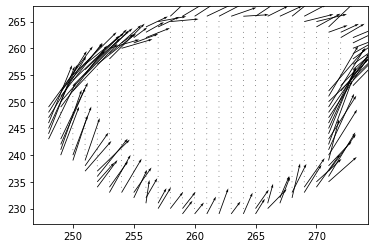

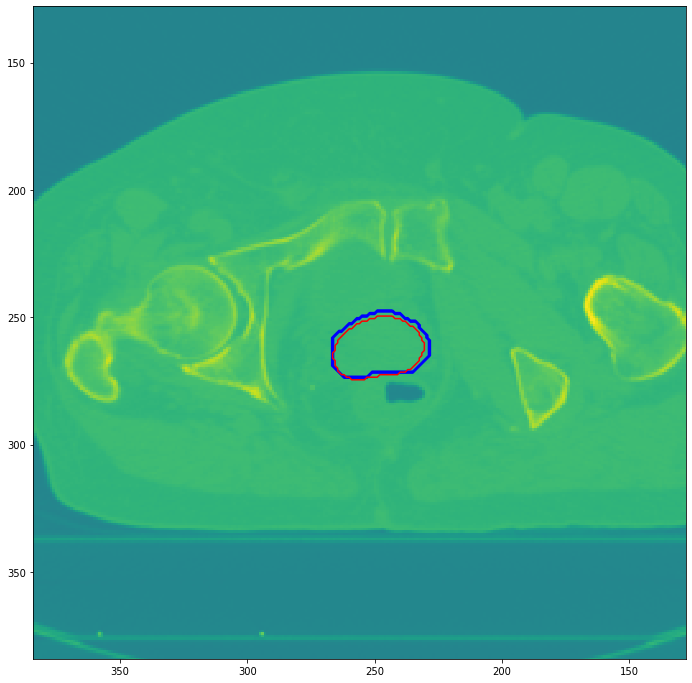

In [16]:
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 30
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 45
circles = 3
organ_i = 1
seed=123
dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
du_1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=True, plot=True, display=True)

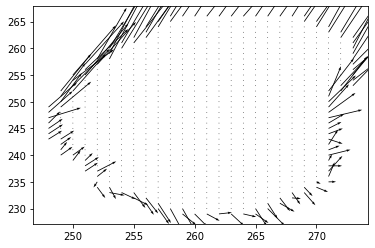

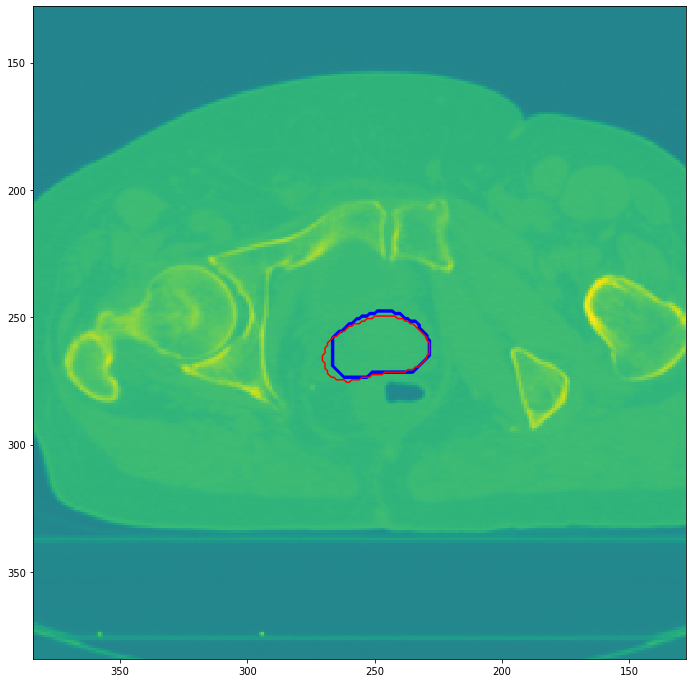

In [17]:
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 30
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 45
circles = 3
organ_i = 1
seed=123
dx, dy, mask, t2, L2, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
du_1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=True, plot=True, display=True)

## Dice calculation

In [18]:
du_test = du_1

In [19]:
def dice_coef(seg, gt, k=1):
    dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))
    return dice

In [20]:
dice = dice_coef(du_test, target_label1, 1)
dice

0.9187096774193548

## Paremeter Experimentation

**1. Different c*SD**

Looking for c with great variation (not too small but not too large)

Limit is 100 since the contour is out of bound after that

In [21]:
def create_log(df, c, k, w, ismax, dice):
    if ismax:
        ismax = "max"
    else: 
        ismax = "min"
    df = df.append({'c' : c, 'k' : k, 'w': w, 'min/max' : ismax, 'dice': dice},  
                ignore_index = True) 
    return df

In [ ]:
dice_list = []
a=50
voxelsize = np.array([0.976562, 0.976562, 2.5])
plt.figure(figsize=(15, 15))
c_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
k = 1
df = pd.DataFrame(columns = ['k', 'c', 'min/max', "dice"]) 
ismax=False
for i in range(len(c_list)):
    c = c_list[i]
    SD=[c*1.7, c*2, c*2.5]
    dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, ismax=ismax, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
    dice = dice_coef(du1, target_label1, 1)
    dice_list.append(dice)
    df = create_log(df, c, k, w, ismax, dice)
    plt.subplot(4, 5, i + 1)
    plt.imshow(target_img1, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.xlim(300, 190)
    plt.ylim(300, 190)
    plt.title("c = " + str(c_list[i]))
    plt.axis('off')

In [ ]:
# plot dice   
plt.plot(c_list, dice_list, label="Dice coef")
plt.ylabel("Dice")
plt.xlabel("c*[1.7, 2, 2.5]")
plt.legend()

20 seem has a lot of variation and also in the good dice (0.86 which is not too high or too low)

**Different k working with best c*SD**

c = 10

In [ ]:
dice_list = []
a=50
voxelsize = np.array([0.976562, 0.976562, 2.5])
plt.figure(figsize=(15, 15))
c = 10
k_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
for i in range(len(k_list)):
    SD=[c*1.7, c*2, c*2.5]
    k = k_list[i]
    dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, ismax=False, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
    dice = dice_coef(du1, target_label1, 1)
    dice_list.append(dice)
    df = create_log(df, c, k, w, ismax, dice)
    plt.subplot(4, 5, i + 1)
    plt.imshow(target_img1, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.xlim(300, 190)
    plt.ylim(300, 190)
    plt.title("k = " + str(c_list[i]))
    plt.axis('off')
# plot dice   
plt.plot(k_list, dice_list, label="dice")
plt.ylabel("dice")
plt.xlabel("k")
plt.legend()

c = 15

In [ ]:
dice_list = []
a=50
voxelsize = np.array([0.976562, 0.976562, 2.5])
plt.figure(figsize=(15, 15))
c = 15
k_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
for i in range(len(k_list)):
    SD=[c*1.7, c*2, c*2.5]
    k = k_list[i]
    dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, ismax=False, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
    dice = dice_coef(du1, target_label1, 1)
    dice_list.append(dice)
    df = create_log(df, c, k, w, ismax, dice)
    plt.subplot(4, 5, i + 1)
    plt.imshow(target_img1, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.xlim(300, 190)
    plt.ylim(300, 190)
    plt.title("k = " + str(c_list[i]))
    plt.axis('off')
# plot dice   
plt.plot(k_list, dice_list, label="dice")
plt.ylabel("dice")
plt.xlabel("k")
plt.legend()

c = 20

In [ ]:
dice_list = []
a=50
voxelsize = np.array([0.976562, 0.976562, 2.5])
plt.figure(figsize=(15, 15))
c = 20
k_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
for i in range(len(k_list)):
    SD=[c*1.7, c*2, c*2.5]
    k = k_list[i]
    dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, ismax=False, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
    dice = dice_coef(du1, target_label1, 1)
    dice_list.append(dice)
    df = create_log(df, c, k, w, ismax, dice)
    plt.subplot(4, 5, i + 1)
    plt.imshow(target_img1, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.xlim(300, 190)
    plt.ylim(300, 190)
    plt.title("k = " + str(c_list[i]))
    plt.axis('off')
# plot dice   
plt.plot(k_list, dice_list, label="dice")
plt.ylabel("dice")
plt.xlabel("k")
plt.legend()

c = 5, k = 5, 10, 15

In [ ]:
df4

**Different w working with best k and c*SD**

c = 5, k = 5

In [ ]:
dice_list = []
a=50
voxelsize = np.array([0.976562, 0.976562, 2.5])
plt.figure(figsize=(15, 15))

c = 5
k = 5
w_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
for i in range(len(w_list)):
    SD=[c*1.7, c*2, c*2.5]
    w = w_list[i]
    dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, ismax=False, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
    dice = dice_coef(du1, target_label1, 1)
    dice_list.append(dice)
    df = create_log(df, c, k, w, ismax, dice)
    plt.subplot(4, 5, i + 1)
    plt.imshow(target_img1, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.xlim(300, 190)
    plt.ylim(300, 190)
    plt.title("w = " + str(w_list[i]))
    plt.axis('off')
# plot dice   
plt.plot(w_list, dice_list, label="dice")
plt.ylabel("dice")
plt.xlabel("w")
plt.legend()

c = 5, k = 5

In [ ]:
dice_list = []
a=50
voxelsize = np.array([0.976562, 0.976562, 2.5])
plt.figure(figsize=(15, 15))

c = 5
k = 10
w_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
for i in range(len(w_list)):
    SD=[c*1.7, c*2, c*2.5]
    w = w_list[i]
    dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, ismax=False, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
    dice = dice_coef(du1, target_label1, 1)
    dice_list.append(dice)
    df = create_log(df, c, k, w, ismax, dice)
    plt.subplot(4, 5, i + 1)
    plt.imshow(target_img1, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.xlim(300, 190)
    plt.ylim(300, 190)
    plt.title("w = " + str(w_list[i]))
    plt.axis('off')
# plot dice   
plt.plot(w_list, dice_list, label="dice")
plt.ylabel("dice")
plt.xlabel("w")
plt.legend()

c = 5, k = 15

In [ ]:
dice_list = []
a=50
voxelsize = np.array([0.976562, 0.976562, 2.5])
plt.figure(figsize=(15, 15))

c = 5
k = 15
w_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
for i in range(len(w_list)):
    SD=[c*1.7, c*2, c*2.5]
    w = w_list[i]
    dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, ismax=False, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
    dice = dice_coef(du1, target_label1, 1)
    dice_list.append(dice)
    df = create_log(df, c, k, w, ismax, dice)
    plt.subplot(4, 5, i + 1)
    plt.imshow(target_img1, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.xlim(300, 190)
    plt.ylim(300, 190)
    plt.title("w = " + str(w_list[i]))
    plt.axis('off')
# plot dice   
plt.plot(w_list, dice_list, label="dice")
plt.ylabel("dice")
plt.xlabel("w")
plt.legend()

**Different ismax working with best w, k and c*SD**

In [ ]:
dice_list = []
a=50
voxelsize = np.array([0.976562, 0.976562, 2.5])
plt.figure(figsize=(15, 15))

c = 5
k = 15
w = 
ismax=True
for i in range(len(w_list)):
    SD=[c*1.7, c*2, c*2.5]
    w = w_list[i]
    dx, dy, mask, t1, L1, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, ismax=False, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
    dice = dice_coef(du1, target_label1, 1)
    dice_list.append(dice)
    df = create_log(df, c, k, w, ismax, dice)
    plt.subplot(4, 5, i + 1)
    plt.imshow(target_img1, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.xlim(300, 190)
    plt.ylim(300, 190)
    plt.title("w = " + str(w_list[i]))
    plt.axis('off')
# plot dice   
plt.plot(w_list, dice_list, label="dice")
plt.ylabel("dice")
plt.xlabel("w")
plt.legend()

**Best set of parameters on different slide**

# testing on different slices

In [ ]:
assd_contour = []

for i in range(12):
    if i != 7:
        dx, dy, mask, t, L, roi_z  = af_Sobel.assd_Sobel(images[65 + i, ...], labels[..., 1][65 + i, ...], voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
        du = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
        du_2 = np.where(du < 0.5, 0, 4)
        assd_contour.append(list(du_2)) #surface
assd_contour = np.array(assd_contour)

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[65 + i , ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(assd_contour[i, ...], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.contour(labels[..., 1][65 + i, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
    plt.xlim(200, 300)
    plt.ylim(300, 200)
    blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
    red_patch = mpatches.Patch(color='red', label='DU contour with random seed 1')
    plt.legend(handles=[ blue_patch, red_patch])
    
plt.axis('off')

In [ ]:
assd_contour.shape

In [ ]:
destination_path = "C:\\Users\\lykha\\OneDrive\\Documents\\1_PhD_Fall_2020\\Research_MDA\\coutour_segmentation_3\\Output"
RTStruct([assd_contour], "prostate", slices, fname=os.path.join(destination_path, 'Prostate_contour.dcm'))

# rectum

# Sobel and 3D Permutation

In [ ]:
a = np.argwhere(labels==True)
a[a[..., 3] == 4][0]

In [ ]:
target_img2 = images[55, ...]
target_label2 = labels[..., 4][55, ...]

In [ ]:
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 20
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 45
circles = 3
organ_i = 4
seed=123
dx, dy, mask, t, L, roi_z = af_Sobel.assd_Sobel(target_img2, target_label2, voxelsize, a, SD, circles, seed, k, w, images, labels, 4, smooth=True)
du_2 = af_Sobel.plotting_assd(dx, dy, mask, target_img2, quiver=True, plot=True, display=True)

# testing on different slices

In [ ]:
assd_contour = []

for i in range(12):
    if i != 7:
        dx, dy, mask, t, L, roi_z  = af_Sobel.assd_Sobel(images[55 + i, ...], labels[..., 4][55 + i, ...], voxelsize, a, SD, circles, seed, k, w, images, labels, 4, smooth=True)
        du = af_Sobel.plotting_assd(dx, dy, mask, target_img2, quiver=False, plot=False)
        du_2 = np.where(du < 0.5, 0, 4)
        assd_contour.append(list(du_2)) #surface
assd_contour = np.array(assd_contour)

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[55 + i , ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(assd_contour[i, ...], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.contour(labels[..., 4][55 + i, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
    plt.xlim(200, 300)
    plt.ylim(300, 200)
    blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
    red_patch = mpatches.Patch(color='red', label='DU contour with random seed 1')
    plt.legend(handles=[ blue_patch, red_patch])
    
plt.axis('off')

dummy_mask = labels
RTStruct([dummy_mask], "rectum", slices, fname=os.path.join(destination_path, 'Rectum_contour.dcm'))

In [ ]:
assd_contour_rectum=assd_contour

In [ ]:
destination_path = "Output"
RTStruct([assd_contour], "rectum", slices, fname=os.path.join(destination_path, 'Rectum_contour.dcm'))